# Semi-Supervised Learning with VAE on Fashion MNIST

This notebook implements semi-supervised learning using Variational Autoencoders (VAEs) on the Fashion MNIST dataset, followed by training an SVM classifier using the features extracted from the VAE. We experiment with different numbers of labeled examples to evaluate the performance of our semi-supervised approach.

## 1. Setup

Start by importing the necessary libraries and setting up the environment.


In [140]:
import torch
from torch.optim import Adam
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

from models.VAE import VAE, loss_function
from data.fashion_mnist import get_fashion_mnist_datasets
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

%load_ext autoreload
%autoreload 2


Using device: cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Hyperparameters

Here, we define the hyperparameters for our experiments.


In [141]:
# Hyperparameters
NUM_LABELS_LIST = [100, 600, 1000, 3000]
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-3
SVM_KERNEL = 'rbf'
# VAE architecture parameters (set to those like M1)
HIDDEN_DIM = 500
Z_DIM = 50


## 3. Helper Functions

We define various functions for training the VAE, extracting features, training and evaluating the SVM, and plotting histograms and random samples.


In [142]:
from tqdm import tqdm

# Function to train VAE
def train_vae(model, labeled_loader, optimizer, epochs=10):
    model.train()
    for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
        train_loss = 0
        # Training on labeled data
        for batch_idx, (data, _) in enumerate(tqdm(labeled_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        # print(f'====> Epoch: {epoch} Average loss: {train_loss / len(labeled_loader.dataset):.4f}')


In [143]:
# Function to extract features using the encoder part of VAE
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            features.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

def evaluate_model(model, clf, data_loader):
    model.eval()
    features, labels = extract_features(model, data_loader)
    pred = clf.predict(features)
    accuracy = accuracy_score(labels, pred)
    return accuracy

In [144]:
# Plot histograms to ensure the data is balanced
def plot_histogram(labeled_loader, unlabeled_loader):
    # Extract labels from the labeled loader
    labeled_labels = []
    for _, labels in labeled_loader:
        labeled_labels.extend(labels.numpy())

    # Extract labels from the unlabeled loader
    unlabeled_labels = []
    for _, labels in unlabeled_loader:
        unlabeled_labels.extend(labels.numpy())

    # Plot histograms
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(labeled_labels, bins=np.arange(11)-0.5, rwidth=0.8, color='blue', edgecolor='black')
    plt.title(f'Labeled Data Distribution (Count: {len(labeled_labels)})')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(range(10))  # Ensure that the bins are recognizable

    plt.subplot(1, 2, 2)
    plt.hist(unlabeled_labels, bins=np.arange(11)-0.5, rwidth=0.8, color='green', edgecolor='black')
    plt.title(f'Unlabeled Data Distribution (Count: {len(unlabeled_labels)})')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(range(10))  # Ensure that the bins are recognizable
    
    plt.tight_layout()
    plt.show()


# Plot some random samples from the dataset
def plot_random_samples(dataset, num_samples=10):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    samples = [dataset[idx][0].numpy().squeeze() for idx in indices]
    labels = [dataset[idx][1] for idx in indices]
    
    plt.figure(figsize=(15, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample, cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()


In [145]:
# Function to train and evaluate the SVM
def train_svm(unlabeled_features, unlabeled_labels):
    # Train SVM classifier using unlabeled data features
    clf = svm.SVC(kernel=SVM_KERNEL)
    clf.fit(unlabeled_features, unlabeled_labels)
    return clf


In [146]:
# Function to run the entire experiment and evaluate results
def train_m1(num_labels):
    labeled_loader, unlabeled_loader, test_loader = get_fashion_mnist_datasets(num_labels)

    # Plot histograms of labeled and unlabeled data
    plot_histogram(labeled_loader, unlabeled_loader)
    
    # Plot some random samples from the dataset
    # plot_random_samples(labeled_loader.dataset.dataset)

    model = VAE(hidden_dim=HIDDEN_DIM, latent_dim=Z_DIM).to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    # Train VAE
    train_vae(model, labeled_loader, optimizer, epochs=EPOCHS)

    # Extract features for classifier training
    unlabeled_features, unlabeled_labels = extract_features(model, unlabeled_loader)

    # Train and evaluate SVM
    clf = train_svm(unlabeled_features, unlabeled_labels)
    accuracy = evaluate_model(model, clf, test_loader)
    
    # Save the VAE and SVM models
    torch.save(model.state_dict(), fr'.\models\vae_model_{num_labels}.pth')
    joblib.dump(clf, fr'.\models\svm_model_{num_labels}.joblib')
    
    return accuracy


## 4. Training

We run the experiment for different numbers of labeled examples and print the accuracy for each case.



Running experiment with 100 labels...


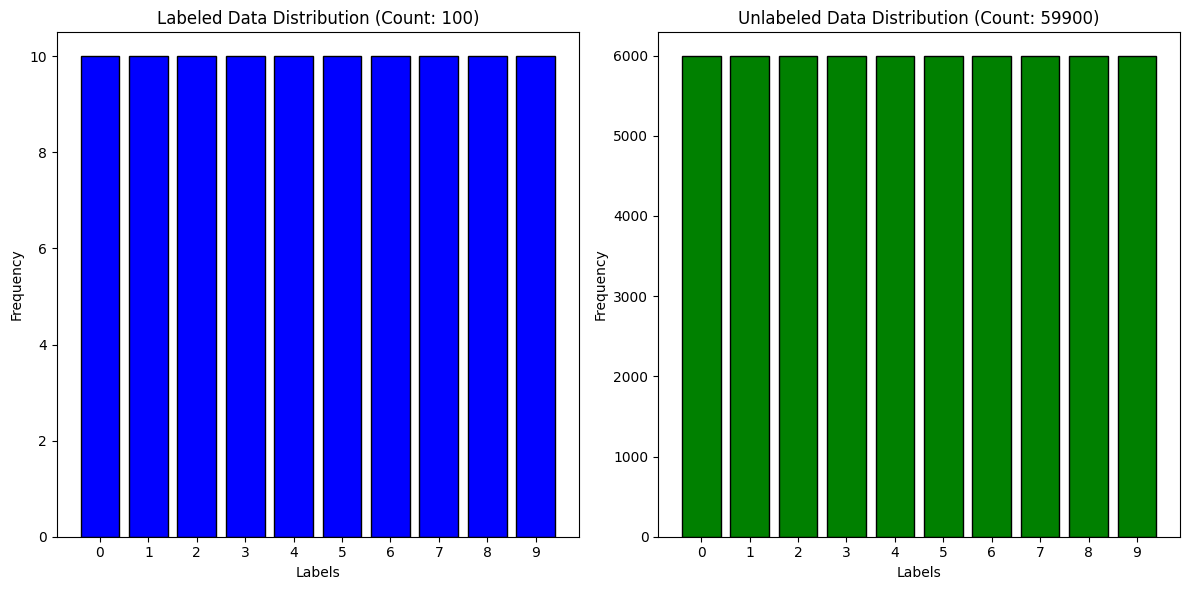

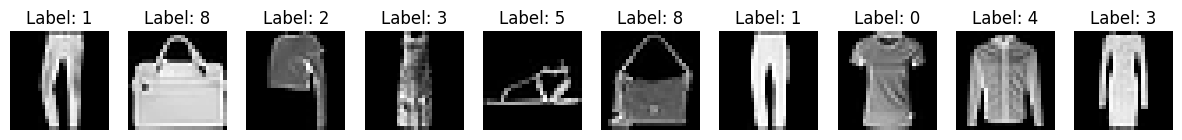

Epochs: 100%|██████████| 100/100 [00:02<00:00, 44.68it/s]


Accuracy with 100 labels: 0.7977

Running experiment with 600 labels...


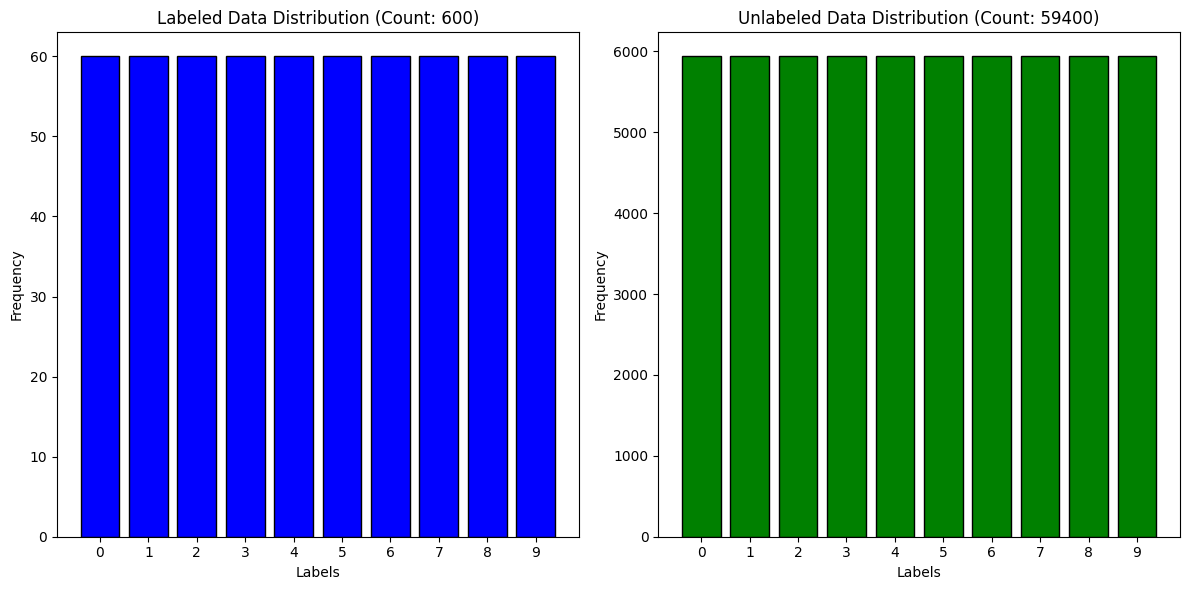

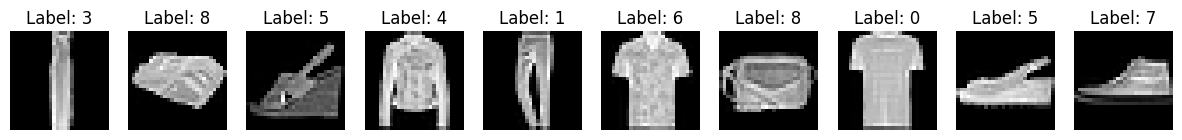

Epochs: 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


Accuracy with 600 labels: 0.8402

Running experiment with 1000 labels...


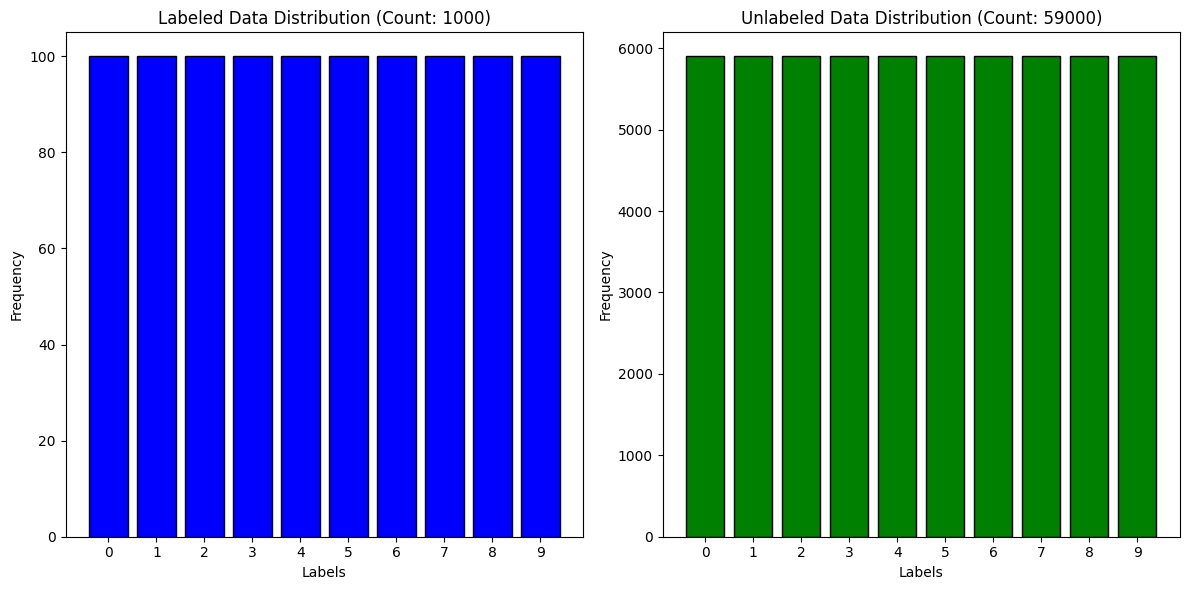

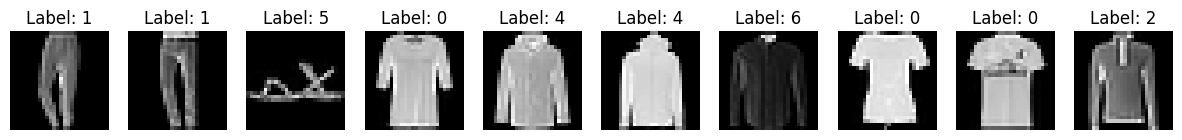

Epochs: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Accuracy with 1000 labels: 0.8516

Running experiment with 3000 labels...


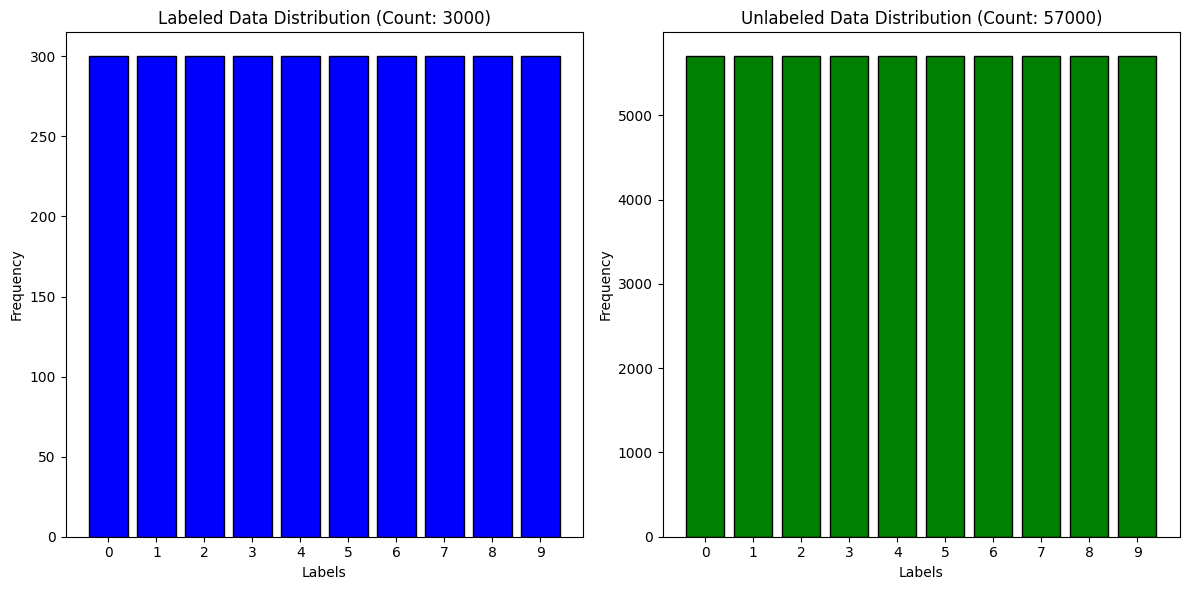

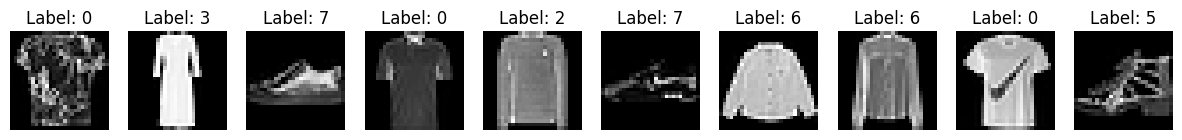

Epochs: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Accuracy with 3000 labels: 0.8605


In [147]:
# Run the experiment for different numbers of labels
for num_labels in NUM_LABELS_LIST:
    print(f"\nRunning experiment with {num_labels} labels...")
    accuracy = train_m1(num_labels)
    print(f'Accuracy with {num_labels} labels: {accuracy:.4f}')


## 5. Evaluation

In this section, we evaluate the saved models by loading them and visualizing the generated samples and classification results.


In [148]:
from data.fashion_mnist import FAHSION_MNIST_CLASSES
# Function to load models and evaluate
def load_and_evaluate_model(num_labels):
    model = VAE().to(device)
    model.load_state_dict(torch.load(fr'.\models\vae_model_{num_labels}.pth'))
    clf = joblib.load(fr'.\models\svm_model_{num_labels}.joblib')
    
    _, _, test_loader = get_fashion_mnist_datasets(num_labels)
    accuracy = evaluate_model(model, clf, test_loader)
    
    print(f'Accuracy with {num_labels} labels (loaded model): {accuracy:.4f}')
    
    # Visualize some generated samples
    visualize_generated_samples(model, clf)
    
    return accuracy

# Function to visualize generated samples
def visualize_generated_samples(model, clf, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        generated = model.decode(z).view(-1, 1, 28, 28)
        features, _ = model.encode(generated.view(-1, 784))
        pred = clf.predict(features)

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            axes[i].imshow(generated[i].cpu().numpy().squeeze(), cmap='gray')
            axes[i].set_title(f'Pred: {FAHSION_MNIST_CLASSES[pred[i]]}', fontsize=8)
            axes[i].axis('off')
        plt.suptitle('Generated Samples')
        plt.show()




Evaluating saved model with 100 labels...
Accuracy with 100 labels (loaded model): 0.7977


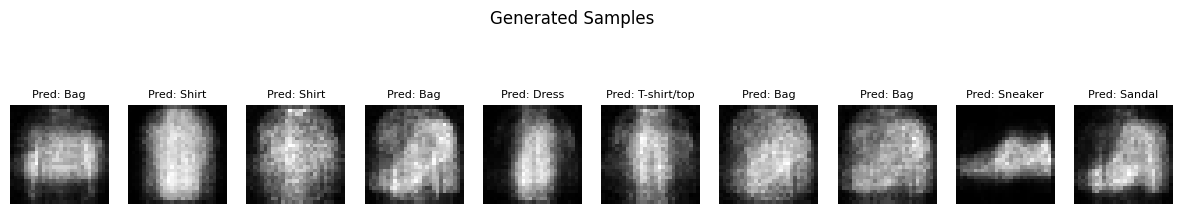


Evaluating saved model with 600 labels...
Accuracy with 600 labels (loaded model): 0.8402


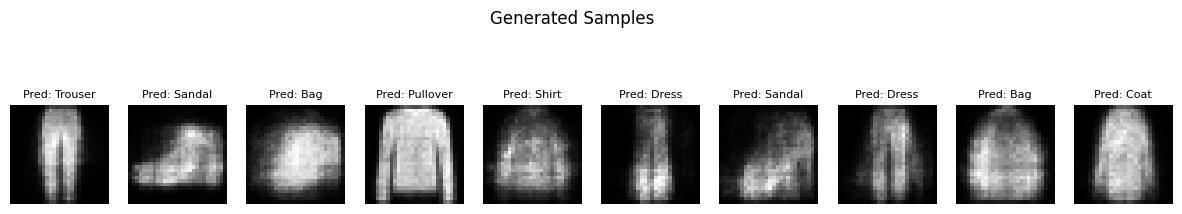


Evaluating saved model with 1000 labels...
Accuracy with 1000 labels (loaded model): 0.8516


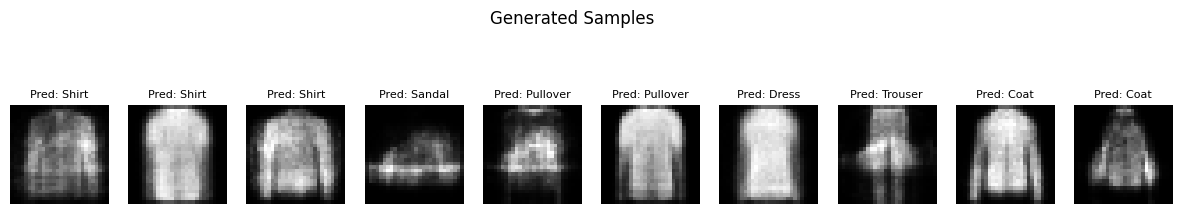


Evaluating saved model with 3000 labels...
Accuracy with 3000 labels (loaded model): 0.8605


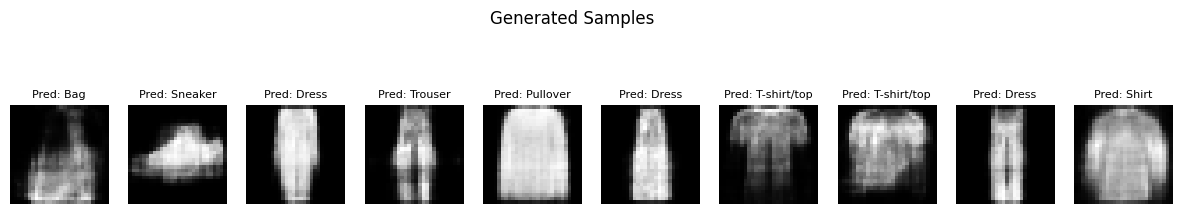

In [149]:
# Load and evaluate saved models
for num_labels in NUM_LABELS_LIST:
    print(f"\nEvaluating saved model with {num_labels} labels...")
    load_and_evaluate_model(num_labels)
